# Прогнозирование оптимальной температуры сплава стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Основная задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Файл data_arc_new.csv

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv

- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv

- key — номер партии;
- Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

Файл data_wire_new.csv

- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv

- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

**Содержание**
<a class="anchor"  id="0"><a/>

- [Обзор исходных данных](#1)
  - [Обзор исходных данных data_arc_new.csv](#1.1)
  - [Обзор исходных данных data_bulk_new.csv](#1.2)
  - [Обзор исходных данных data_bulk_time_new.csv](#1.3)
  - [Обзор исходных данных data_gas_new.csv](#1.4)
  - [Обзор исходных данных data_temp_new.csv](#1.5)
  - [Обзор исходных данных data_wire_new.csv](#1.6)
  - [Обзор исходных данных data_wire_time_new.csv](#1.7)
- [Подготовка данных](#2)
  - [Создание признаков](#2.1)
  - [Объединение данных](#2.2)
- [Исследовательский анализ](#3)
- [Корреляционный анализ](#4)
- [Обучение моделей](#5)
  - [Пайплайн и разделение данных](#5.1)
  - [Обучение модели линейной регрессии](#5.2)
  - [Обучение модели случайного леса](#5.3)
  - [Обучение модели градиентного бустинга](#5.4)
  - [Анализ моделей](#5.5)
  - [Тестирование лучшей модели](#5.6)
- [Анализ важности признаков](#6)
- [Общий вывод](#7)

In [1]:
# Блок с импортами.

!pip install phik -q
!pip install shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import cv
#import shap

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [2]:
# Константы.

TEST_SIZE = 0.25
RANDOM_STATE = 61025

In [3]:
try:
    temp = pd.read_csv('C:/Users/alfer/DS_projects/final/data_temp_new.csv')
    arc = pd.read_csv('C:/Users/alfer/DS_projects/final/data_arc_new.csv')
    bulk = pd.read_csv('C:/Users/alfer/DS_projects/final/data_bulk_new.csv')
    bulk_time = pd.read_csv('C:/Users/alfer/DS_projects/final/data_bulk_time_new.csv')
    gas = pd.read_csv('C:/Users/alfer/DS_projects/final/data_gas_new.csv')
    wire = pd.read_csv('C:/Users/alfer/DS_projects/final/data_wire_new.csv')
    wire_time = pd.read_csv('C:/Users/alfer/DS_projects/final/data_wire_time_new.csv')
except:
    temp = pd.read_csv('/datasets/data_temp_new.csv')
    arc = pd.read_csv('/datasets/data_arc_new.csv')
    bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('/datasets/data_gas_new.csv')
    wire = pd.read_csv('/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

## Обзор исходных данных
<a id="1"><a/>

### Обзор исходных данных data_arc_new.csv
<a id="1.1"><a/>

In [4]:
# Функция для обзора исходных данных.
def df_informer(df):
    print('Первые 20 строк таблицы: \n')
    display(df.head(20))
    print('Общая информация о данных: \n')
    display(df.info())
    print('Количество явных дубликатов: ', df.duplicated().sum())
    print('Сводная статистика по данным: \n')
    display(df.describe().T)
    #display(df.describe(include='object').T)
    #display(df.describe(include='datetime').T)

In [5]:
# Функция для построения гистограммы и диаграммы размаха.
def hist_und_box(df, column, axes_name, title, y_label):
    sns.set(rc={'figure.figsize': (15, 5)})
    fig, axes = plt.subplots(1, 2)
    
    sns.histplot(data=df[column], bins=30, ax=axes[0], color='green')
    axes[0].set(ylabel=y_label, xlabel=axes_name)
    
    sns.boxplot(data=df[column], ax=axes[1], color='green')
    axes[1].set(ylabel=axes_name)
    
    plt.suptitle(title)
    plt.show()

In [6]:
df_informer(arc)

Первые 20 строк таблицы: 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


In [7]:
arc.describe(include='object').T

,count,unique,top,freq
Начало нагрева дугой,14876,14876,2019-07-05 03:27:53,1
Конец нагрева дугой,14876,14876,2019-06-06 13:47:08,1


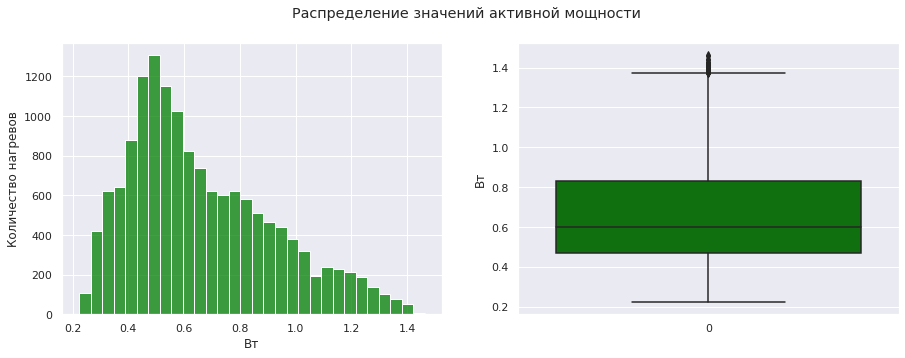

In [8]:
hist_und_box(arc, 'Активная мощность', 'Вт', 'Распределение значений активной мощности', 'Количество нагревов')

Среди значений реактивной мощности обнаружилось отрицательное значение. Уберём его.

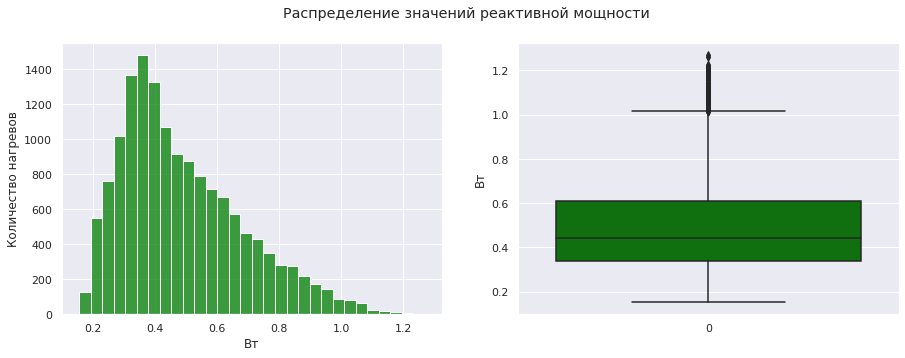

In [9]:
arc = arc[arc['Реактивная мощность'] > 0]
hist_und_box(arc, 'Реактивная мощность', 'Вт', 'Распределение значений реактивной мощности', 'Количество нагревов')

Наблюдаем 14876 записей о подаваемой активной и реактивной мощности и времени нагрева. Распределение значений нормальное со смещением влево.

[Назад к содержанию](#0)

### Обзор исходных данных data_bulk_new.csv
<a id="1.2"><a/>

In [10]:
df_informer(bulk)

Первые 20 строк таблицы: 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Наблюдаем множество пропусков в данных о примесях. Пропуски указывают на случаи, когда примеси не добавлялись, соответственно логично заметить пропуски на нули. Также уберём признаки, доля пропусков в которых выше 20%, — нет смысла ожидать, что модель хорошо установи связь с целевым при столь малом количестве данных.

In [11]:
bulk = bulk.drop(['Bulk 1','Bulk 2', 'Bulk 5', 'Bulk 6', 'Bulk 7','Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'], axis= 1)

In [12]:
bulk.fillna(0, inplace=True)
bulk.head()

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


Все значения, похоже, целочисленные. Приведём их к соответствующему типу.

In [13]:
bulk = bulk.astype('int64')
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   Bulk 3   3129 non-null   int64
 2   Bulk 4   3129 non-null   int64
 3   Bulk 12  3129 non-null   int64
 4   Bulk 14  3129 non-null   int64
 5   Bulk 15  3129 non-null   int64
dtypes: int64(6)
memory usage: 146.8 KB


[Назад к содержанию](#0)

### Обзор исходных данных data_bulk_time_new.csv
<a id="1.3"><a/>

In [14]:
df_informer(bulk_time)

Первые 20 строк таблицы: 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Наблюдаем 3129 записей о времени подачи сыпучих материалов. Оставим данные неизменными, для построения модели они не пригодятся.

[Назад к содержанию](#0)

### Обзор исходных данных data_gas_new.csv
<a id="1.4"><a/>

In [15]:
df_informer(gas)

Первые 20 строк таблицы: 



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


В датафрейме представлено больше партий, чем в данных с примесями. Проверим нет ли повторяющихся.

In [16]:
len(gas['key'].unique())

3239

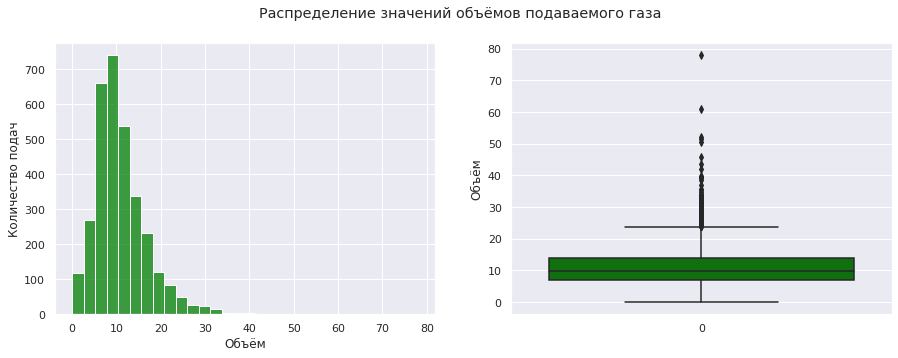

In [17]:
hist_und_box(gas, 'Газ 1', 'Объём', 'Распределение значений объёмов подаваемого газа', 'Количество подач')

Наблюдаем 3239 записей об объёме подаваемого газа. Объёмы больше 25 являются достаточно редкими. 

[Назад к содержанию](#0)

### Обзор исходных данных data_temp_new.csv
<a id="1.5"><a/>

In [18]:
df_informer(temp)

Первые 20 строк таблицы: 



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


In [19]:
len(temp['key'].unique())

3216

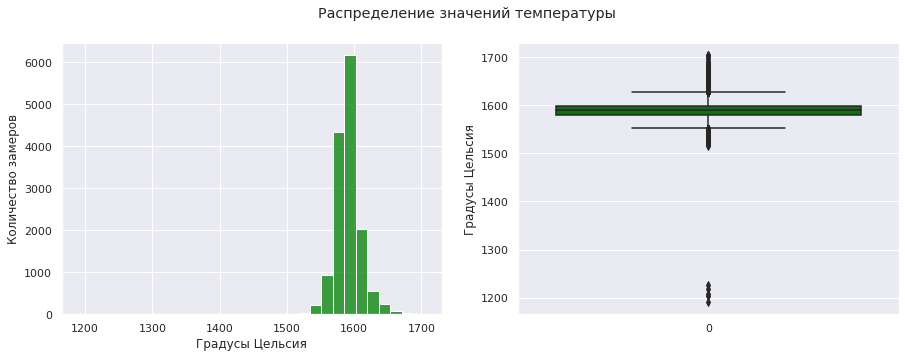

In [20]:
hist_und_box(temp, 'Температура', 'Градусы Цельсия', 'Распределение значений температуры', 'Количество замеров')

Наблюдаем данные с замерами температуры сплава 3216-ти партий. Целевым значением для предсказания в данном случае являются последние замеры каждой партии. Можно отметить минимальное значение температуры в 1191℃, что не является корректным значением плавления стали. Важно проследить, чтобы такие значения не попали на вход модели. Наблюдаем также массу пропусков в значениях температуры, в дальнейшем их обработаем.

[Назад к содержанию](#0)

### Обзор исходных данных data_wire_new.csv
<a id="1.6"><a/>

In [21]:
df_informer(wire)

Первые 20 строк таблицы: 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [22]:
len(wire['key'].unique())

3081

Наблюдаем 3081 запись об объёме поданных проволочных материалов. Имеется масса пропусков, но вероятно она указывают на то, какие материалы поданы не были. Уберём неинформативные признаки и заменим пропуски на нули.

In [23]:
wire = wire.drop(['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis= 1)
wire.fillna(0, inplace=True)
wire.head()

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


[Назад к содержанию](#0)

### Обзор исходных данных data_wire_time_new.csv
<a id="1.7"><a/>

In [24]:
df_informer(wire_time)

Первые 20 строк таблицы: 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Наблюдаем 3081 запись времени подачи проволочного материала. Пропуски обусловлены случаями, когда маттериал не подавался. Не похоже,  что информация нам пригодится.

**Результаты изучения исходных данных и первичной обработки:**

- Данные об электродах содержат 14876 записей о подаваемой активной и реактивной мощности и времени нагрева. Распределение значений нормальное со смещением влево. В процессе первичной обработки удалены отрицательные значения реактивной мощности.
- Данные о сыпучих материалах содержат 3129 записей. В процессе обработки удалены признаки, доля пропусков в которых превышает 80%. Оставшиеся пропуски заполнены нулями. Все значения приведены к целочисленному типу.
- Данные об объёме подаваемого газа содержат 3239 записей. Объёмы больше 25 являются достаточно редкими.
- Данные о проволочных материалах содержат 3081 запись. С пропусками и малоинформативными признаками произведены манипуляции аналогичные обработке данных о сыпучих материалах.
- Данные о времени подачи материалов признаны неинформативными.

[Назад к содержанию](#0)

## Подготовка данных
<a id="2"><a/>

### Создание признаков
<a id="2.1"><a/>

**arc**

На основе имеющихся данных создадим следующие признаки:

- **full_power** — полная поданая мощность на электрроды.
- **operation** — работа тока.
- **cos_φ** — коэффициэнт мощности.

In [25]:
# Переведём значения времени к корректному типу.
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 1.2 MB


In [26]:
arc['duration'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']
arc['duration'] = arc['duration'].apply(lambda x: x.total_seconds())
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [27]:
arc['full_power'] = ((arc['Активная мощность'] ** 2) + (arc['Реактивная мощность'] ** 2)) ** 0.5
arc['operation'] = arc['full_power'] * arc['duration']
#arc['cos_φ'] = arc['Активная мощность'] / arc['full_power']
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,duration,full_power,operation
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


In [28]:
power_values = arc[['key', 'operation', 'full_power', 'Активная мощность', 'duration']].groupby('key').sum()
power_values['cos_φ'] = power_values['Активная мощность'] / power_values['full_power']
power_values.head()

,operation,full_power,Активная мощность,duration,cos_φ
key,,,,,
1,770.282114,3.718736,3.036730,1098.0,0.816603
2,481.760005,2.588349,2.139408,811.0,0.826553
3,722.837668,5.019223,4.063641,655.0,0.809615
4,683.455597,3.400038,2.706489,741.0,0.796017
5,512.169934,2.816980,2.252950,869.0,0.799775


**temp**

В данном датасете важно выделить целевое значение каждой партии и проследить, чтобы оно не было некорректным (температура ниже 1400℃). Также нужно что-то сделать с пропусками. Корректно заполнить их, кажется, не получится. Попробуем просто убрать их из датасета.

In [29]:
temp = temp.dropna()

In [30]:
# Проверим не оказались ли в датасете единичные измерения.
temp['key'].value_counts()

2108    17
1513    16
1689    16
322     14
46      14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3216, dtype: int64

В наборе данных имеются партии с одним измерением температуры. Из описания производственного процесса можно сделать вывод, что измерений должно быть минимум два. Соответственно либо часть данных утеряна, либо мы имеем дело с партиями, химический состав и температура которых не требовали корректировок. Уберём данные значения.

In [31]:
temp_counts = temp.groupby('key').count()
temp_counts.columns = ['key_counts', 'key_counts_double']
temp = temp.merge(temp_counts, on='key', how='left')
temp = temp[temp['key_counts'] > 1]
temp = temp.drop(['key_counts', 'key_counts_double'], axis=1)

Выделим два признака:

- **first_temp** — результат первого замера температуры. Данное значение будет известно до входа в модель и в будущем, значит можем попробовать его использовать.
- **target_temp** — целевое значение температуры.

In [32]:
temp_values = temp.groupby('key').agg(['first', 'last']).reset_index()
temp_values.columns = ['key', 'first_time', 'last_time', 'first_temp', 'target_temp']
temp_values = temp_values[['key', 'first_temp', 'target_temp']]
temp_values.head()

,key,first_temp,target_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [33]:
# Проверим, остались ли пропуски и некорректные значения.
print(temp_values.info())
temp_values.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2475 non-null   int64  
 1   first_temp   2475 non-null   float64
 2   target_temp  2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB
None


,count,mean,std,min,25%,50%,75%,max
key,2475.0,1250.787071,719.787271,1.0,629.5,1252.0,1872.5,2499.0
first_temp,2475.0,1588.402020,29.243044,1191.0,1572.0,1588.0,1605.0,1679.0
target_temp,2475.0,1595.336162,16.023153,1541.0,1587.0,1593.0,1599.0,1700.0


Пропущенные значения в важные нам признаки не попали, но некорректная температура всё же попала в целевой. Исправляем.

In [34]:
temp_values = temp_values[temp_values['first_temp'] > 1400]
temp_values = temp_values[temp_values['target_temp'] > 1400]
temp_values.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2471.0,1250.484015,720.109488,1.0,628.5,1252.0,1872.5,2499.0
first_temp,2471.0,1589.012950,25.004369,1519.0,1572.0,1588.0,1605.0,1679.0
target_temp,2471.0,1595.339943,16.035215,1541.0,1587.0,1593.0,1599.0,1700.0


[Назад к содержанию](#0)

### Объединение данных
<a id="2.2"><a/>

In [35]:
metal = temp_values.merge(power_values, on='key', how='inner')
metal = metal.merge(wire, on='key', how='inner')
metal = metal.merge(bulk, on='key', how='inner')
metal = metal.merge(gas, on='key', how='inner')
metal

,key,first_temp,target_temp,operation,full_power,Активная мощность,duration,cos_φ,Wire 1,Wire 2,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,770.282114,3.718736,3.036730,1098.0,0.816603,60.059998,0.00000,0,43,206,150,154,29.749986
1,2,1581.0,1602.0,481.760005,2.588349,2.139408,811.0,0.826553,96.052315,0.00000,0,73,206,149,154,12.555561
2,3,1596.0,1599.0,722.837668,5.019223,4.063641,655.0,0.809615,91.160157,0.00000,0,34,205,152,153,28.554793
3,4,1601.0,1625.0,683.455597,3.400038,2.706489,741.0,0.796017,89.063515,0.00000,0,81,207,153,154,18.841219
4,5,1576.0,1602.0,512.169934,2.816980,2.252950,869.0,0.799775,89.238236,9.11456,0,78,203,151,152,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,694.177326,3.868721,3.168133,723.0,0.818910,89.150879,0.00000,21,0,256,129,223,7.125735
2321,2496,1554.0,1591.0,815.818538,5.070316,4.174918,940.0,0.823404,114.179527,0.00000,0,63,256,129,226,9.412616
2322,2497,1571.0,1589.0,823.020520,4.360918,3.605239,569.0,0.826716,94.086723,9.04800,0,85,230,124,226,6.271699
2323,2498,1591.0,1594.0,581.810739,3.909917,3.202310,750.0,0.819022,118.110717,0.00000,90,0,206,129,207,14.953657


In [36]:
metal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2325 non-null   int64  
 1   first_temp         2325 non-null   float64
 2   target_temp        2325 non-null   float64
 3   operation          2325 non-null   float64
 4   full_power         2325 non-null   float64
 5   Активная мощность  2325 non-null   float64
 6   duration           2325 non-null   float64
 7   cos_φ              2325 non-null   float64
 8   Wire 1             2325 non-null   float64
 9   Wire 2             2325 non-null   float64
 10  Bulk 3             2325 non-null   int64  
 11  Bulk 4             2325 non-null   int64  
 12  Bulk 12            2325 non-null   int64  
 13  Bulk 14            2325 non-null   int64  
 14  Bulk 15            2325 non-null   int64  
 15  Газ 1              2325 non-null   float64
dtypes: float64(10), int64(6)

**Результаты подготовки данных:**

Для входа в модель подготовлены новые признаки:

- **full_power** — полная поданая мощность на электрроды.
- **operation** — работа тока.
- **cos_φ** — коэффициэнт мощности.
- **first_temp** — результат первого замера температуры. Данное значение будет известно до входа в модель и в будущем, значит можем попробовать его использовать.
- **target_temp** — целевое значение температуры.

Среди данных о температуре удалены пропуски. Партии, которые имели только один замер температуры также были сброшены. По итогу шага все признаки, подготовленные для входа в модель, объединены в один датафрейм.

[Назад к содержанию](#0)

## Исследовательский анализ
<a id="3"><a/>

Выведем распределения вошедших в датасет признаков.

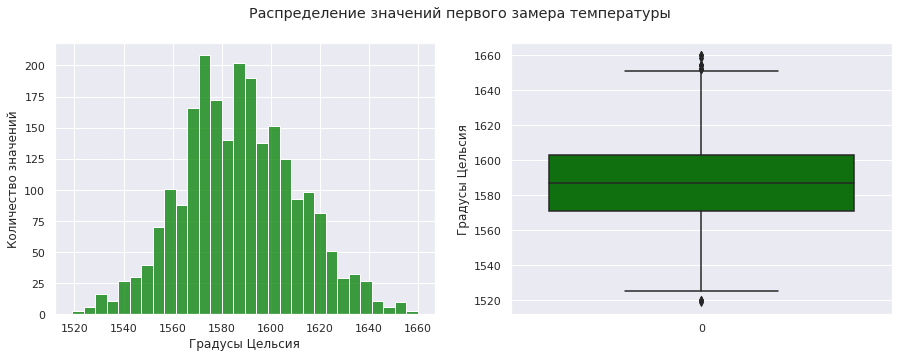

In [37]:
hist_und_box(metal, 'first_temp', 'Градусы Цельсия', 'Распределение значений первого замера температуры', 'Количество значений')

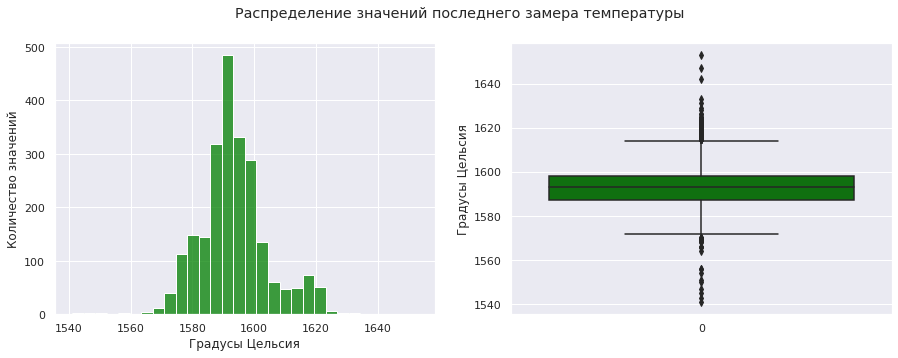

In [38]:
hist_und_box(metal, 'target_temp', 'Градусы Цельсия', 'Распределение значений последнего замера температуры', 'Количество значений')

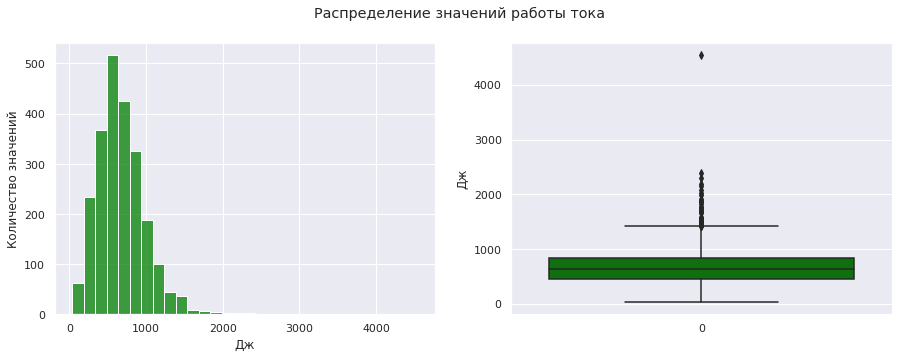

In [39]:
hist_und_box(metal, 'operation', 'Дж', 'Распределение значений работы тока', 'Количество значений')

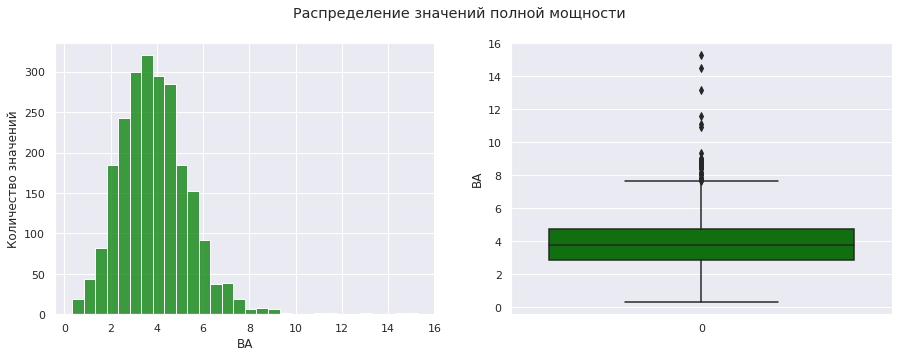

In [40]:
hist_und_box(metal, 'full_power', 'ВА', 'Распределение значений полной мощности', 'Количество значений')

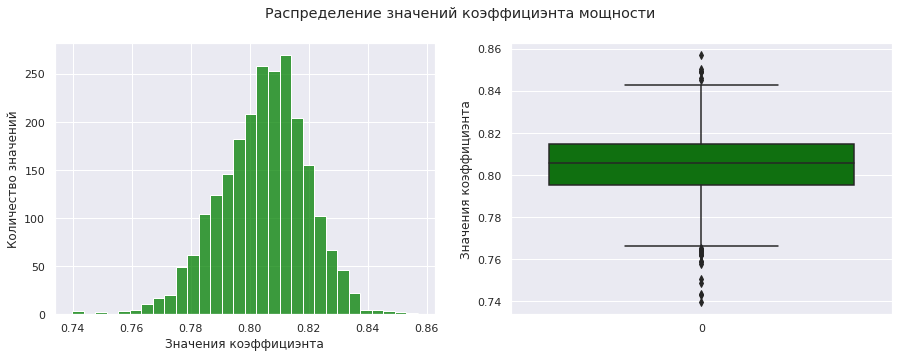

In [41]:
hist_und_box(metal, 'cos_φ', 'Значения коэффициэнта', 'Распределение значений коэффициэнта мощности', 'Количество значений')

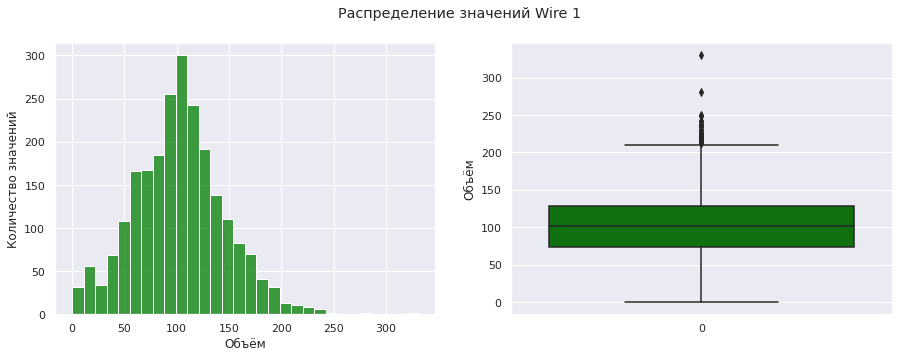

In [42]:
hist_und_box(metal, 'Wire 1', 'Объём', 'Распределение значений Wire 1', 'Количество значений')

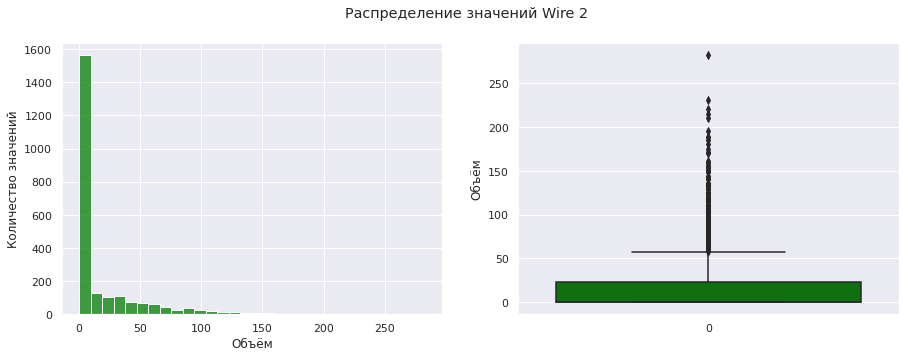

In [43]:
hist_und_box(metal, 'Wire 2', 'Объём', 'Распределение значений Wire 2', 'Количество значений')

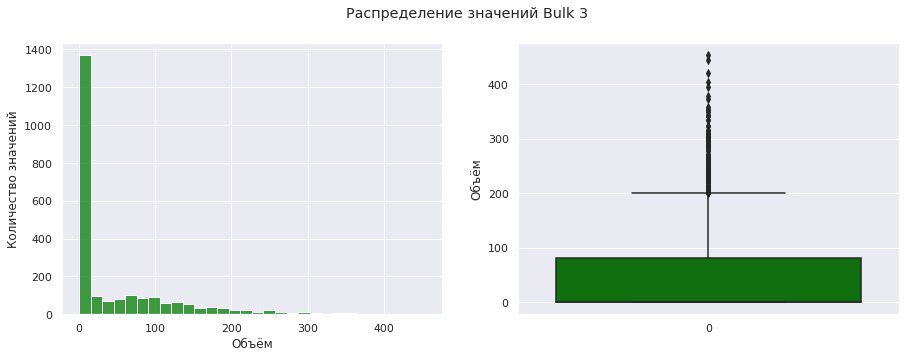

In [44]:
hist_und_box(metal, 'Bulk 3', 'Объём', 'Распределение значений Bulk 3', 'Количество значений')

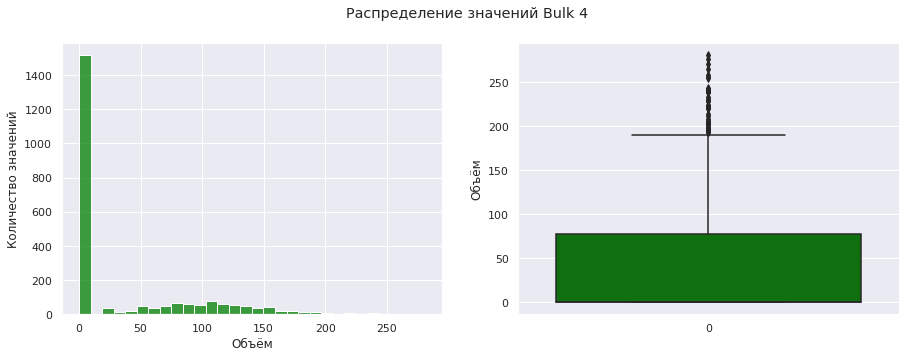

In [45]:
hist_und_box(metal, 'Bulk 4', 'Объём', 'Распределение значений Bulk 4', 'Количество значений')

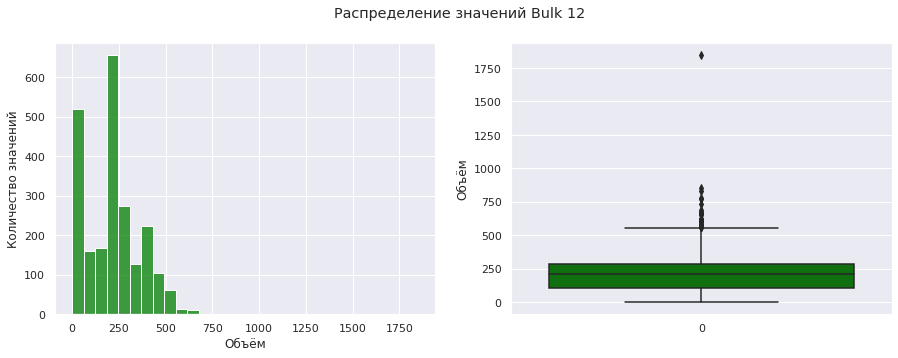

In [46]:
hist_und_box(metal, 'Bulk 12', 'Объём', 'Распределение значений Bulk 12', 'Количество значений')

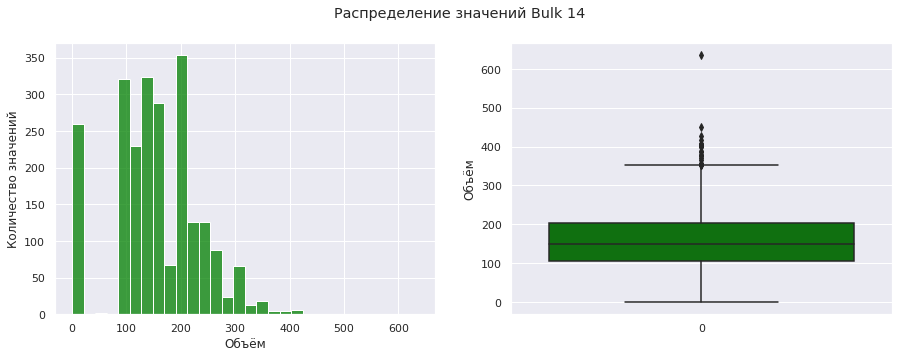

In [47]:
hist_und_box(metal, 'Bulk 14', 'Объём', 'Распределение значений Bulk 14', 'Количество значений')

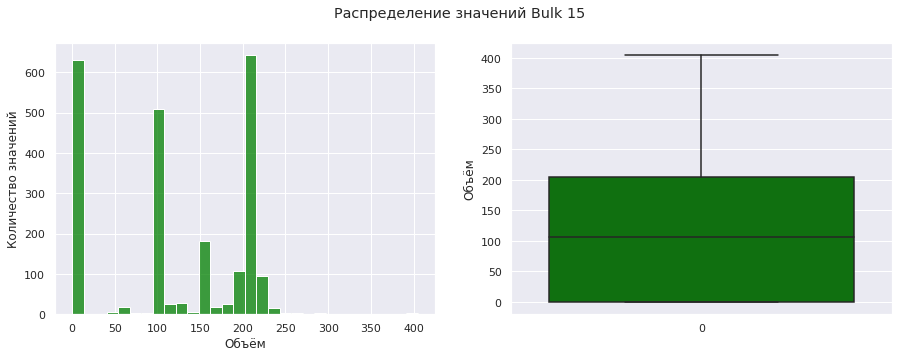

In [48]:
hist_und_box(metal, 'Bulk 15', 'Объём', 'Распределение значений Bulk 15', 'Количество значений')

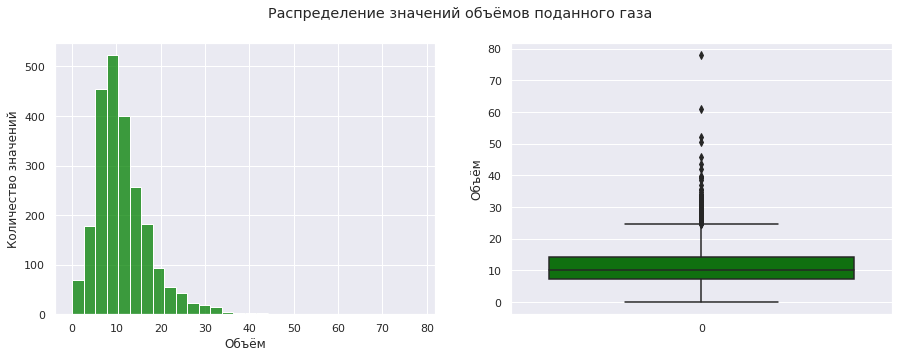

In [49]:
hist_und_box(metal, 'Газ 1', 'Объём', 'Распределение значений объёмов поданного газа', 'Количество значений')

**По итогу изучения графиков можем отметить:**

- Большая часть признаков имеет имеет ненормальное распределение.
- Целевое значение темперауры чаще всего имеет значение 1590—1600℃.
- Распределение значений подаваемых сыпучих и проволочных материалов в основном имеет ненормальное распределение либо ввиду количества введённых вместо пропусков нулей, либо ввиду неизвестного на момент исследования технологического процесса.

[Назад к содержанию](#0)

## Корреляционный анализ
<a id="4"><a/>

Взглянем на корреляцию между признаками.

In [50]:
# Функция для отображения матрицы корреляции.
def phik_matrix_creator(df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.drop(['key'], axis=1).phik_matrix(
    interval_cols=[
        'first_temp',
        'target_temp',
        'operation',
        'full_power',
        'cos_φ',
        'Wire 1',
        'Wire 2',
        'Bulk 3',
        'Bulk 4',
        'Bulk 12',
        'Bulk 14',
        'Bulk 15',
        'Газ 1',
        'Активная мощность',
        'duration'
    ]
), annot=True, cmap='coolwarm', fmt='.2f')

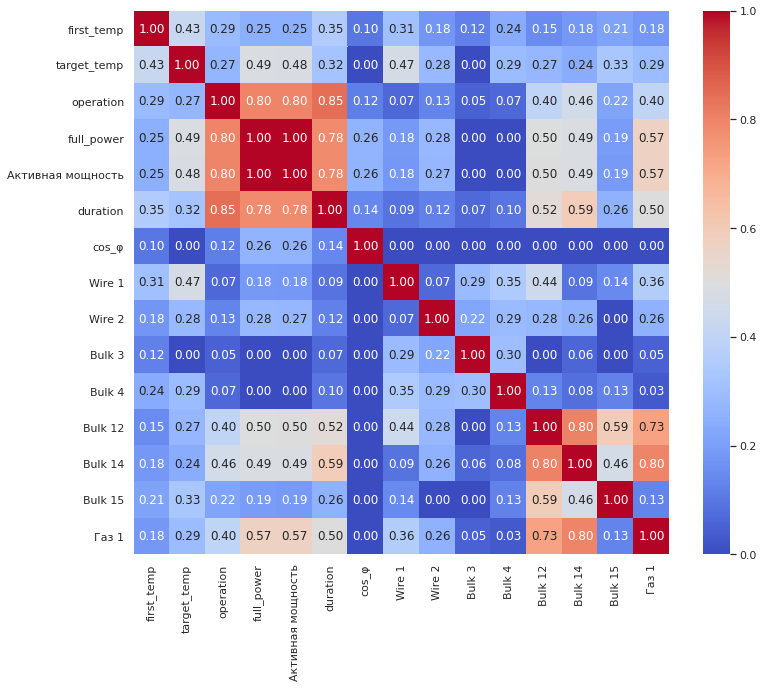

In [51]:
phik_matrix_creator(metal)

**Анализ матрицы корреляции:**

- Заметнее всего коррелируют с целевой температурой значения полной мощности, первого замера температуры, активной мощности и материала **Wire 1**.
- Значения коэффициэнта мощности не показали связи с целевым.
- Значения сыпучего материала **Bulk 3** также никак не коррелируют с целевой температурой.
- Остальные признаки слабо или умеренно коррелируют с целевым признаком.

Можно также отметить, что значения активной мощности показывают полную связь со значениями полной. Уберём мультиколлиннеарность.

In [52]:
metal = metal.drop(['Активная мощность'], axis=1)

[Назад к содержанию](#0)

## Обучение моделей
<a id="5"><a/>

### Пайплайн и разделение данных
<a id="5.1"><a/>

Добавим пайплайн для масштабирования значений входных признаков.

In [53]:
# Зададим количественные признаки.
num_columns = ['first_temp', 
               'operation',
               'full_power',
               'cos_φ',
               'Wire 1',
               'Wire 2',
               'Bulk 3',
               'Bulk 4',
               'Bulk 12',
               'Bulk 14',
               'Bulk 15',
               'Газ 1',
               'duration']

In [54]:
# Пайплайн для обработки входных признаков.
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

И, наконец, разделим выборки.

In [55]:
# Разделяем таргет и входные признаки.
X = metal.drop(['key', 'target_temp'], axis=1)
y = metal['target_temp']

# Разделяем данные на тренировочные и тестовые.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# Проверим размерность полученных выборок.
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1743, 13)
X_test: (582, 13)
y_train: (1743,)
y_test: (582,)


### Обучение модели линейной регрессии
<a id="5.2"><a/>

In [56]:
# Cоздаём итоговый пайплайн.
linear_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
) 

In [57]:
params = {}

linear_model = RandomizedSearchCV(
    linear_pipe,
    params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=5,
    cv=2,
    verbose=5,
    random_state=RANDOM_STATE,
)

linear_model.fit(X_train, y_train)
linear_train_time = linear_model.cv_results_['mean_fit_time'][linear_model.best_index_]

cv_mae_linear = abs(linear_model.best_score_)
print('Лучшая модель: \n', linear_model.best_estimator_)
print('MAE на кросс-валидации:', cv_mae_linear)
print('Среднее время обучения модели:', linear_train_time, 'cекунд')

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ................................................ total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/2] END ................................................ total time=   0.2s
Лучшая модель: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['first_temp', 'operation',
                                                   'full_power', 'cos_φ',
                                                   'Wire 1', 'Wire 2', 'Bulk 3',
                                                   'Bulk 4', 'Bulk 12',
                                                   'Bulk 14', 'Bulk 15',
                                                   'Газ 1', 'duration'])])),
                ('models', LinearRegression())])
MAE на кросс-валидации: 6.571354010129251
Среднее время обучения модели: 0.0995628833770752 cекунд


### Обучение модели случайного леса
<a id="5.3"><a/>

In [58]:
forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

In [59]:
forest_params = {
    'n_estimators': range(50, 150, 10),
    'max_depth': range(5, 30, 5),
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False]
}

rf_model = RandomizedSearchCV(
    forest_model,
    forest_params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=RANDOM_STATE,
)

rf_model.fit(X_train, y_train)

cv_mae_rf = abs(rf_model.best_score_)

rf_model.best_estimator_.fit(X_train, y_train)
rf_train_time = rf_model.cv_results_['mean_fit_time'][linear_model.best_index_]
#rf_pred_time = rf_model.cv_results_['mean_score_time'][linear_model.best_index_]

print('Лучшая модель: \n', rf_model.best_estimator_)
print('MAE на кросс-валидации:', cv_mae_rf)
print('Среднее время обучения модели:', rf_train_time, 'cекунд')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, max_depth=25, min_samples_split=2, n_estimators=110; total time=   1.7s
[CV 2/5] END bootstrap=False, max_depth=25, min_samples_split=2, n_estimators=110; total time=   1.6s
[CV 3/5] END bootstrap=False, max_depth=25, min_samples_split=2, n_estimators=110; total time=   1.6s
[CV 4/5] END bootstrap=False, max_depth=25, min_samples_split=2, n_estimators=110; total time=   2.1s
[CV 5/5] END bootstrap=False, max_depth=25, min_samples_split=2, n_estimators=110; total time=   3.1s
[CV 1/5] END bootstrap=False, max_depth=25, min_samples_split=8, n_estimators=60; total time=   0.8s
[CV 2/5] END bootstrap=False, max_depth=25, min_samples_split=8, n_estimators=60; total time=   0.8s
[CV 3/5] END bootstrap=False, max_depth=25, min_samples_split=8, n_estimators=60; total time=   0.8s
[CV 4/5] END bootstrap=False, max_depth=25, min_samples_split=8, n_estimators=60; total time=   0.8s
[CV 5/5] END bootstrap=Fa

### Обучение модели градиентного бустинга
<a id="5.4"><a/>

In [60]:
catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', verbose=False)

params = {
    'n_estimators': [100, 250, 500],
    'depth': [4, 10]
}

catboost_model = RandomizedSearchCV(
    catboost,
    params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=5,
    cv=3,
    verbose=5,
    random_state=RANDOM_STATE,
)

catboost_model.fit(X_train, y_train)

cv_mae_catboost = abs(catboost_model.best_score_)
catboost_train_time = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]

print('Лучшая модель: \n', catboost_model.best_estimator_)
print('Среднее время обучения модели:', catboost_train_time, 'cекунд')
print('MAE на кросс-валидации:', cv_mae_catboost)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .....................depth=10, n_estimators=100; total time=   3.9s
[CV 2/3] END .....................depth=10, n_estimators=100; total time=   3.8s
[CV 3/3] END .....................depth=10, n_estimators=100; total time=   3.9s
[CV 1/3] END .....................depth=10, n_estimators=500; total time=  16.5s
[CV 2/3] END .....................depth=10, n_estimators=500; total time=  16.3s
[CV 3/3] END .....................depth=10, n_estimators=500; total time=  16.5s
[CV 1/3] END ......................depth=4, n_estimators=100; total time=   0.8s
[CV 2/3] END ......................depth=4, n_estimators=100; total time=   0.9s
[CV 3/3] END ......................depth=4, n_estimators=100; total time=   0.9s
[CV 1/3] END .....................depth=10, n_estimators=250; total time=   8.2s
[CV 2/3] END .....................depth=10, n_estimators=250; total time=   8.4s
[CV 3/3] END .....................depth=10, n_est

### Анализ моделей
<a id="5.5"><a/>

Соберём вместе результаты обучения моделей.

In [61]:
results = {
    'model': ['LinearRegression', 'RandomForest', 'CatBoost'],
    'train_time (seconds)': [linear_train_time, rf_train_time, catboost_train_time],
    #'pred_time (seconds)': [linear_pred_time, rf_pred_time, catboost_pred_time],
    'cv_mae': [cv_mae_linear, cv_mae_rf, cv_mae_catboost]
}

models = pd.DataFrame(results)
models

,model,train_time (seconds),cv_mae
0,LinearRegression,0.099563,6.571354
1,RandomForest,1.994802,6.629228
2,CatBoost,1.245905,6.513565


Все модели смогли преодолеть порог качества. Лучше всего с задачей справилась модель градиентного бустинга, соответственно тестирование проведём на ней.

### Тестирование лучшей модели
<a id="5.6"><a/>

In [62]:
predictions = catboost_model.predict(X_test)
print('MАE лучшей модели на тестовой выборке:', (mean_absolute_error(y_test, predictions)))

MАE лучшей модели на тестовой выборке: 5.9694978169036235


**Результаты обучения моделей**

Были обучены три модели:

**LinearRegression:**

- MAE на кросс-валидации: 6.571354010129251
- Среднее время обучения модели: 0.0995628833770752 cекунд

**RandomForestRegressor:**

- MAE на кросс-валидации: 6.629228144698128
- Среднее время обучения модели: 1.9948018074035645 cекунд

**CatBoostRegressor:**

- Среднее время обучения модели: 1.2459049224853516 cекунд
- MAE на кросс-валидации: 6.5135646935129765

По итогу анализа результатов обучения лучшей признана модель градиентного бустинга. На тестовой выборке метрика MАE достигла значения 5.9694978169036235 (заданный порог качества МАЕ <= 6.8).

[Назад к содержанию](#0)

## Анализ важности признаков
<a id="6"><a/>

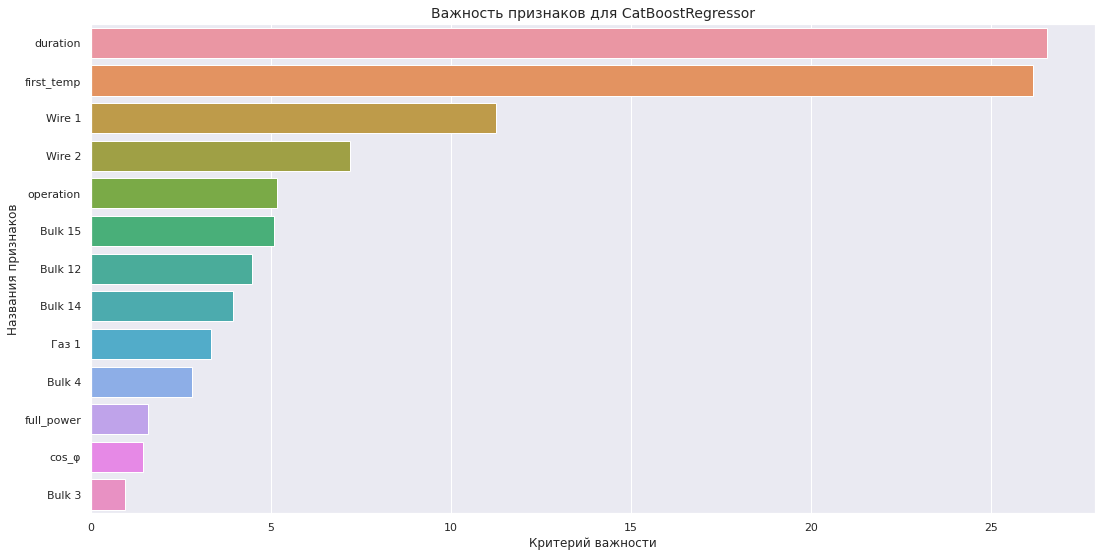

In [63]:
feature_importance_data = {
    'features': X_test.columns,
    'feature_importances': catboost_model.best_estimator_.feature_importances_,
}
feature_importance_data = pd.DataFrame(feature_importance_data)
feature_importance_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=feature_importance_data['feature_importances'], y=feature_importance_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Высокую важность признака изначальной температуры в целом можно связать с тем, что эти значения уже находятся близко к целевой. Взглянем подробнее на работу тока.

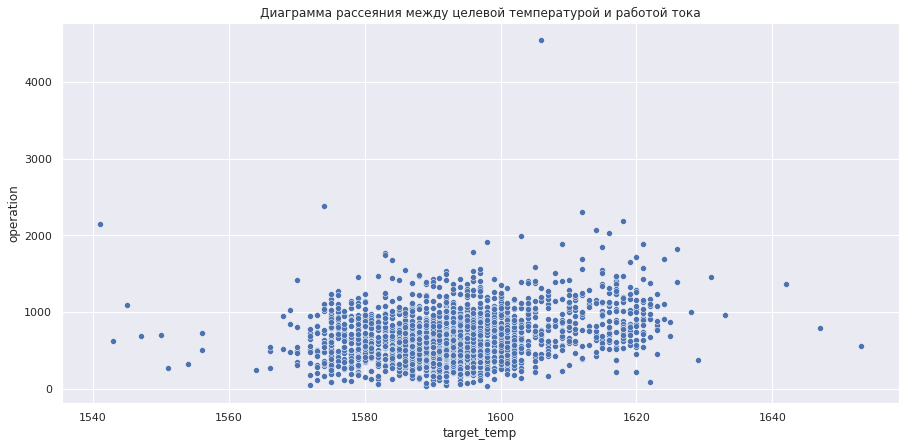

In [64]:
# Построим диаграмму рассеяния.
sns.set(rc={'figure.figsize': (15, 7)})
sns.scatterplot(data=metal, x='target_temp', y='operation')
plt.title('Диаграмма рассеяния между целевой температурой и работой тока')
plt.show()

Большая часть значений не требовала выполненной работы свыше 1000 Дж. Но это число могло бы быть меньше, если бы мы исключили моменты, когда мы тратили время на нагрев и подавали бы мощность на электроды, но не получали нагрева сплава или вообще теряли бы градусы. Собственно, предовращая такие случаи, и можно было бы экономить электроэнергию. Возможно, большинство таких случаев можно было бы предотвратить, подавая на ковш постоянную полную мощность.

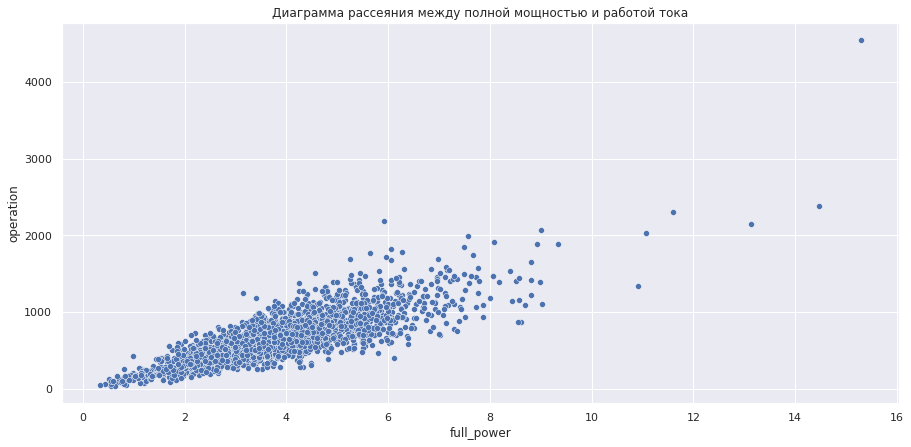

In [65]:
sns.scatterplot(data=metal, x='full_power', y='operation')
plt.title('Диаграмма рассеяния между полной мощностью и работой тока')
plt.show()

In [66]:
metal[metal['full_power'] <= 6]['full_power'].count() / metal['full_power'].count()

0.9238709677419354

Значений полной мощности около 6 ВА было бы достаточно, чтобы выполнить работу тока, которая требовалась для нагрева сплава в 92.38709677419354% случаев.

**Анализ графика:**

- Сильнее всего на результат предсказания влияют длительность нагрева и результат первого измерения температуры.
- Из нематериальных данных заметно влияет на результат работа тока.
- Заметно влияют на температуру материалы **Wire 1** и **Wire 2**.

[Назад к содержанию](#0)

## Общий вывод
<a id="7"><a/>

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Исходя из этой цели была поставлена задача: создать модель, способную предсказывать оптимальное значение температуры сплава.

Для решения задачи были проделаны следующие шаги:

**1 Обзор исходных данных**

**Результаты изучения исходных данных и первичной обработки:**

- Данные об электродах содержат 14876 записей о подаваемой активной и реактивной мощности и времени нагрева. Распределение значений нормальное со смещением влево. В процессе первичной обработки удалены отрицательные значения реактивной мощности.
- Данные о сыпучих материалах содержат 3129 записей. В процессе обработки удалены признаки, доля пропусков в которых превышает 80%. Оставшиеся пропуски заполнены нулями. Все значения приведены к целочисленному типу.
- Данные об объёме подаваемого газа содержат 3239 записей. Объёмы больше 25 являются достаточно редкими.
- Данные о проволочных материалах содержат 3081 запись. С пропусками и малоинформативными признаками произведены манипуляции аналогичные обработке данных о сыпучих материалах.
- Данные о времени подачи материалов признаны неинформативными.

**2 Подготовка данных**

**Результаты подготовки данных:**

Для входа в модель подготовлены новые признаки:

- **full_power** — полная поданая мощность на электрроды.
- **operation** — работа тока.
- **cos_φ** — коэффициэнт мощности.
- **first_temp** — результат первого замера температуры. Данное значение будет известно до входа в модель и в будущем, значит можем попробовать его использовать.
- **target_temp** — целевое значение температуры.

Среди данных о температуре удалены пропуски. Партии, которые имели только один замер температуры также были сброшены. По итогу шага все признаки, подготовленные для входа в модель, объединены в один датафрейм.

**3 Исследовательский анализ**

**По итогу изучения графиков отметили следующее:**

- Большая часть признаков имеет нормальное распределение со смещением влево.
- Целевое значение темперауры чаще всего имеет значение 1590—1600℃.
- Распределение значений поаваемых сыпучих и проволочных материалов в основном имеет ненормальное распределение либо ввиду количества введённых вместо пропусков нулей, либо ввиду неизвестного на момент исследования технологического процесса.

**4 Корреляционный анализ**

**Анализ матрицы корреляции:**

- Заметнее всего коррелируют с целевой температурой значения полной мощности, первого замера температуры, активной мощности и материала **Wire 1**.
- Значения коэффициэнта мощности не показали связи с целевым.
- Значения сыпучего материала **Bulk 3** также никак не коррелируют с целевой температурой.
- Остальные признаки слабо или умеренно коррелируют с целевым признаком.

По итогу анализа устранена мультиколлинеарность — удалён признак со значениями активной мощности.

**5 Обучение моделей**

Были обучены три модели:

**LinearRegression:**

- MAE на кросс-валидации: 6.571354010129251
- Среднее время обучения модели: 0.0995628833770752 cекунд

**RandomForestRegressor:**

- MAE на кросс-валидации: 6.629228144698128
- Среднее время обучения модели: 1.9948018074035645 cекунд

**CatBoostRegressor:**

- Среднее время обучения модели: 1.2459049224853516 cекунд
- MAE на кросс-валидации: 6.5135646935129765

По итогу анализа результатов обучения лучшей признана модель градиентного бустинга. На тестовой выборке метрика MАE достигла значения 5.9694978169036235 (заданный порог качества МАЕ <= 6.8).

**6 Анализ важности признаков**

- Сильнее всего на результат предсказания влияют длительность нагрева и результат первого измерения температуры.
- Из нематериальных данных заметно влияет на результат работа тока.
- Заметно влияют на температуру материалы **Wire 1** и **Wire 2**.

По итогу дополнительного анализа можно сформулировать следующую рекомендацию: 

Можно зафиксировать подаваемую на электроды полную мощность на уровне 5—6 ВА. Это сократило бы время нагрева, а также позволило бы избегать большей части случаев, когда мощности подаётся недостаточно для нагрева сплава до целевой температуры.